# Australian Boreholes

Looking at the data from the [**Australian Borehole Stratigraphic Unit Compilation**](https://ecat.ga.gov.au/geonetwork/srv/eng/catalog.search#/metadata/147641) 2023 v1.0

In [18]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as plt
import pygmt
from joblib import Parallel, delayed
import requests
import zipfile
import io
import os
from shapely import Point
from tqdm import tqdm
import re
from copy import copy

from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException 

In [2]:
absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit
absuc.set_index("GA_GUID", inplace=True)
# remove entries with NaNs in the seemingly relevant depth measurements
absuc.dropna(
    axis=0,
    subset=("TD_MD_M", "TOP_MD_M", "BASE_MD_M", "TOP_AHD_M", "BASE_AHD_M", "GA_ASUD_NO"),
    inplace=True,
)

# remove some irrelevant columns
absuc.drop(
    labels=[
        "OBJECTID",
        "GA_ENO",
        "UWI",
        "GL_AHD_M",
        "WD_AHD_M",
        "SRTM_HE_AHD_M",
        "DATUM_ELEVATION_AHD_M",
        "DATA_SOURCE",
        "GA_HYDROSTRAT",
        "TAG",
        "Z_M_SRTM",
        "COMMENT",
    ],
    axis=1,
    inplace=True
)

absuc.shape

/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_99782/2116727152.py:1: DtypeWarning: Columns (4,28) have mixed types. Specify dtype option on import or set low_memory=False.
  absuc = pd.read_csv("../data/ABSUC/ABSUC_v1_BASE.txt")  # preferred stratigraphic picks for the base of each unit


(278175, 16)

In [3]:
# Get unique boreholes (HIERARCHY == min)
# THIS TAKES A WHILE!
# Running as a loop is faster than parallelising with joblib because of startup cost of lots of little processes.  Could potentially batch.
ids = absuc["GA_BOREHOLE_GUID"].unique()
_drop_these = []
for _id in tqdm(ids):
    subset = absuc[absuc["GA_BOREHOLE_GUID"] == _id]
    best = np.min(subset["HIERARCHY"].unique())
    _drop_these.append(subset[subset["HIERARCHY"] != best].index.values)
_drop_these = np.concatenate(_drop_these)
absuc.drop(_drop_these, axis=0, inplace=True)
del _drop_these
absuc.shape

100%|██████████| 89374/89374 [13:20<00:00, 111.61it/s]


(219926, 16)

In [3]:
# create geometry
absuc["geometry"] = absuc.apply(lambda x: Point(x.GDA94_LONGITUDE, x.GDA94_LATITUDE), axis=1)
absuc = gpd.GeoDataFrame(absuc)

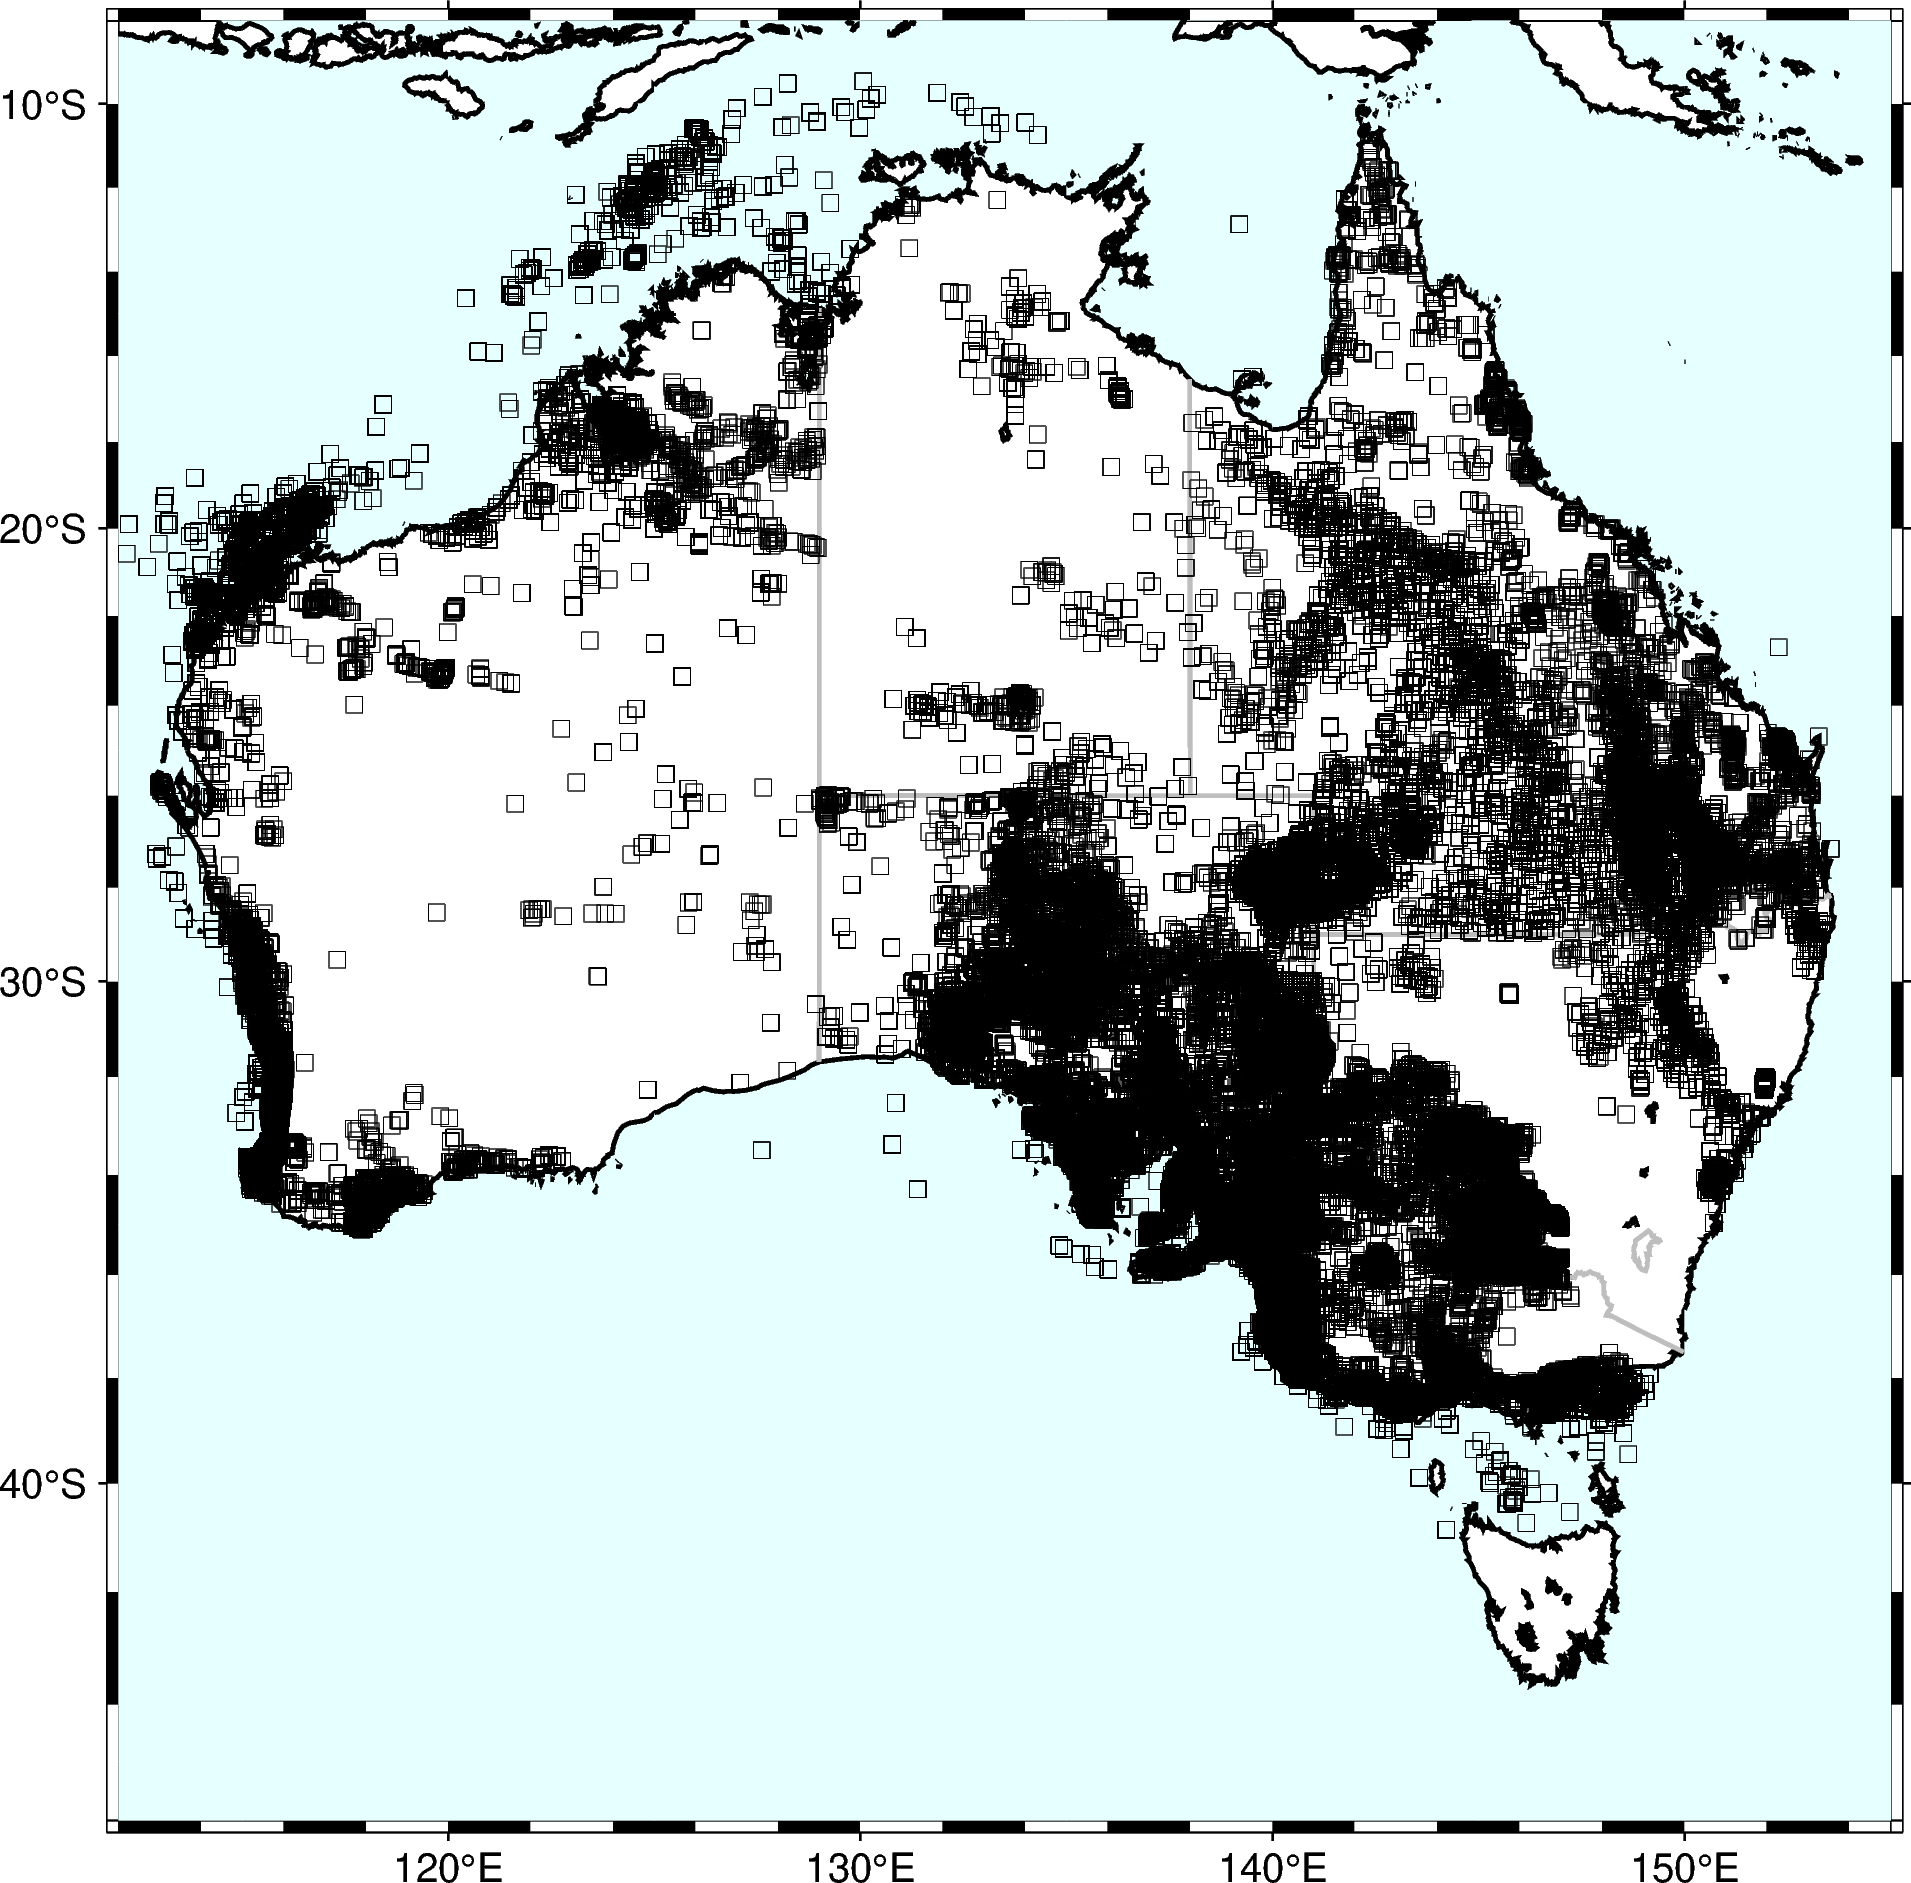

In [4]:
fig = pygmt.Figure()
fig_width = 15
region=[112, 155, -46, -8]
ln_min, ln_max, lt_min, lt_max = region
projection = f"M{int(np.mean([ln_min, ln_max]))}/{int(np.mean([lt_min, lt_max]))}/{fig_width}c"
fig.basemap(region=region, projection=projection, frame=True)
fig.coast(
    region=region,
    projection=projection,
    shorelines=1,
    resolution="i",
    water="#e6ffff",
    borders="2/1p,grey",
)
x = absuc.GDA94_LONGITUDE
y = absuc.GDA94_LATITUDE
fig.plot(x=x,
         y=y,
         style=f"sc",
         pen="0.1p",
         size=np.full_like(x, 0.2))
fig.show()

Try a couple boreholes in SA and see if we can estimate something similar to what is given on SARIG

In [5]:
datadir = os.path.join("..", "data", "SA_drillholes")
if not os.path.exists(datadir):
    print("downloading...")
    r = requests.get("https://data.sarig.sa.gov.au/Map/Download/layerDownload?layeId=924&formatLovId=20")
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall(path=datadir)
    with open(os.path.join(datadir, ".gitignore"), "w") as f:
        f.write("*")
SA = gpd.read_file(os.path.join(datadir, "drillholes_depthtobasement.shp"))
SA.columns

Index(['GDA94_X', 'STRATDESC', 'STRAT_NAME', 'COVR_THICK', 'MAXAGE', 'MINAGE',
       'MAPUNIT', 'ELEVATION', 'BASEMNT_RL', 'ADJLCC_Y', 'ADJLCC_X', 'LCC_Y01',
       'LCC_X02', 'ADJGDA94_Y', 'ADJGDA94_X', 'GDA94_Y03', 'ADJ_ELEV',
       'MAX_DEPTH', 'TO_DEPTH', 'FROM_DEPTH', 'DHNUMBER', 'DH_NAME',
       'geometry'],
      dtype='object')

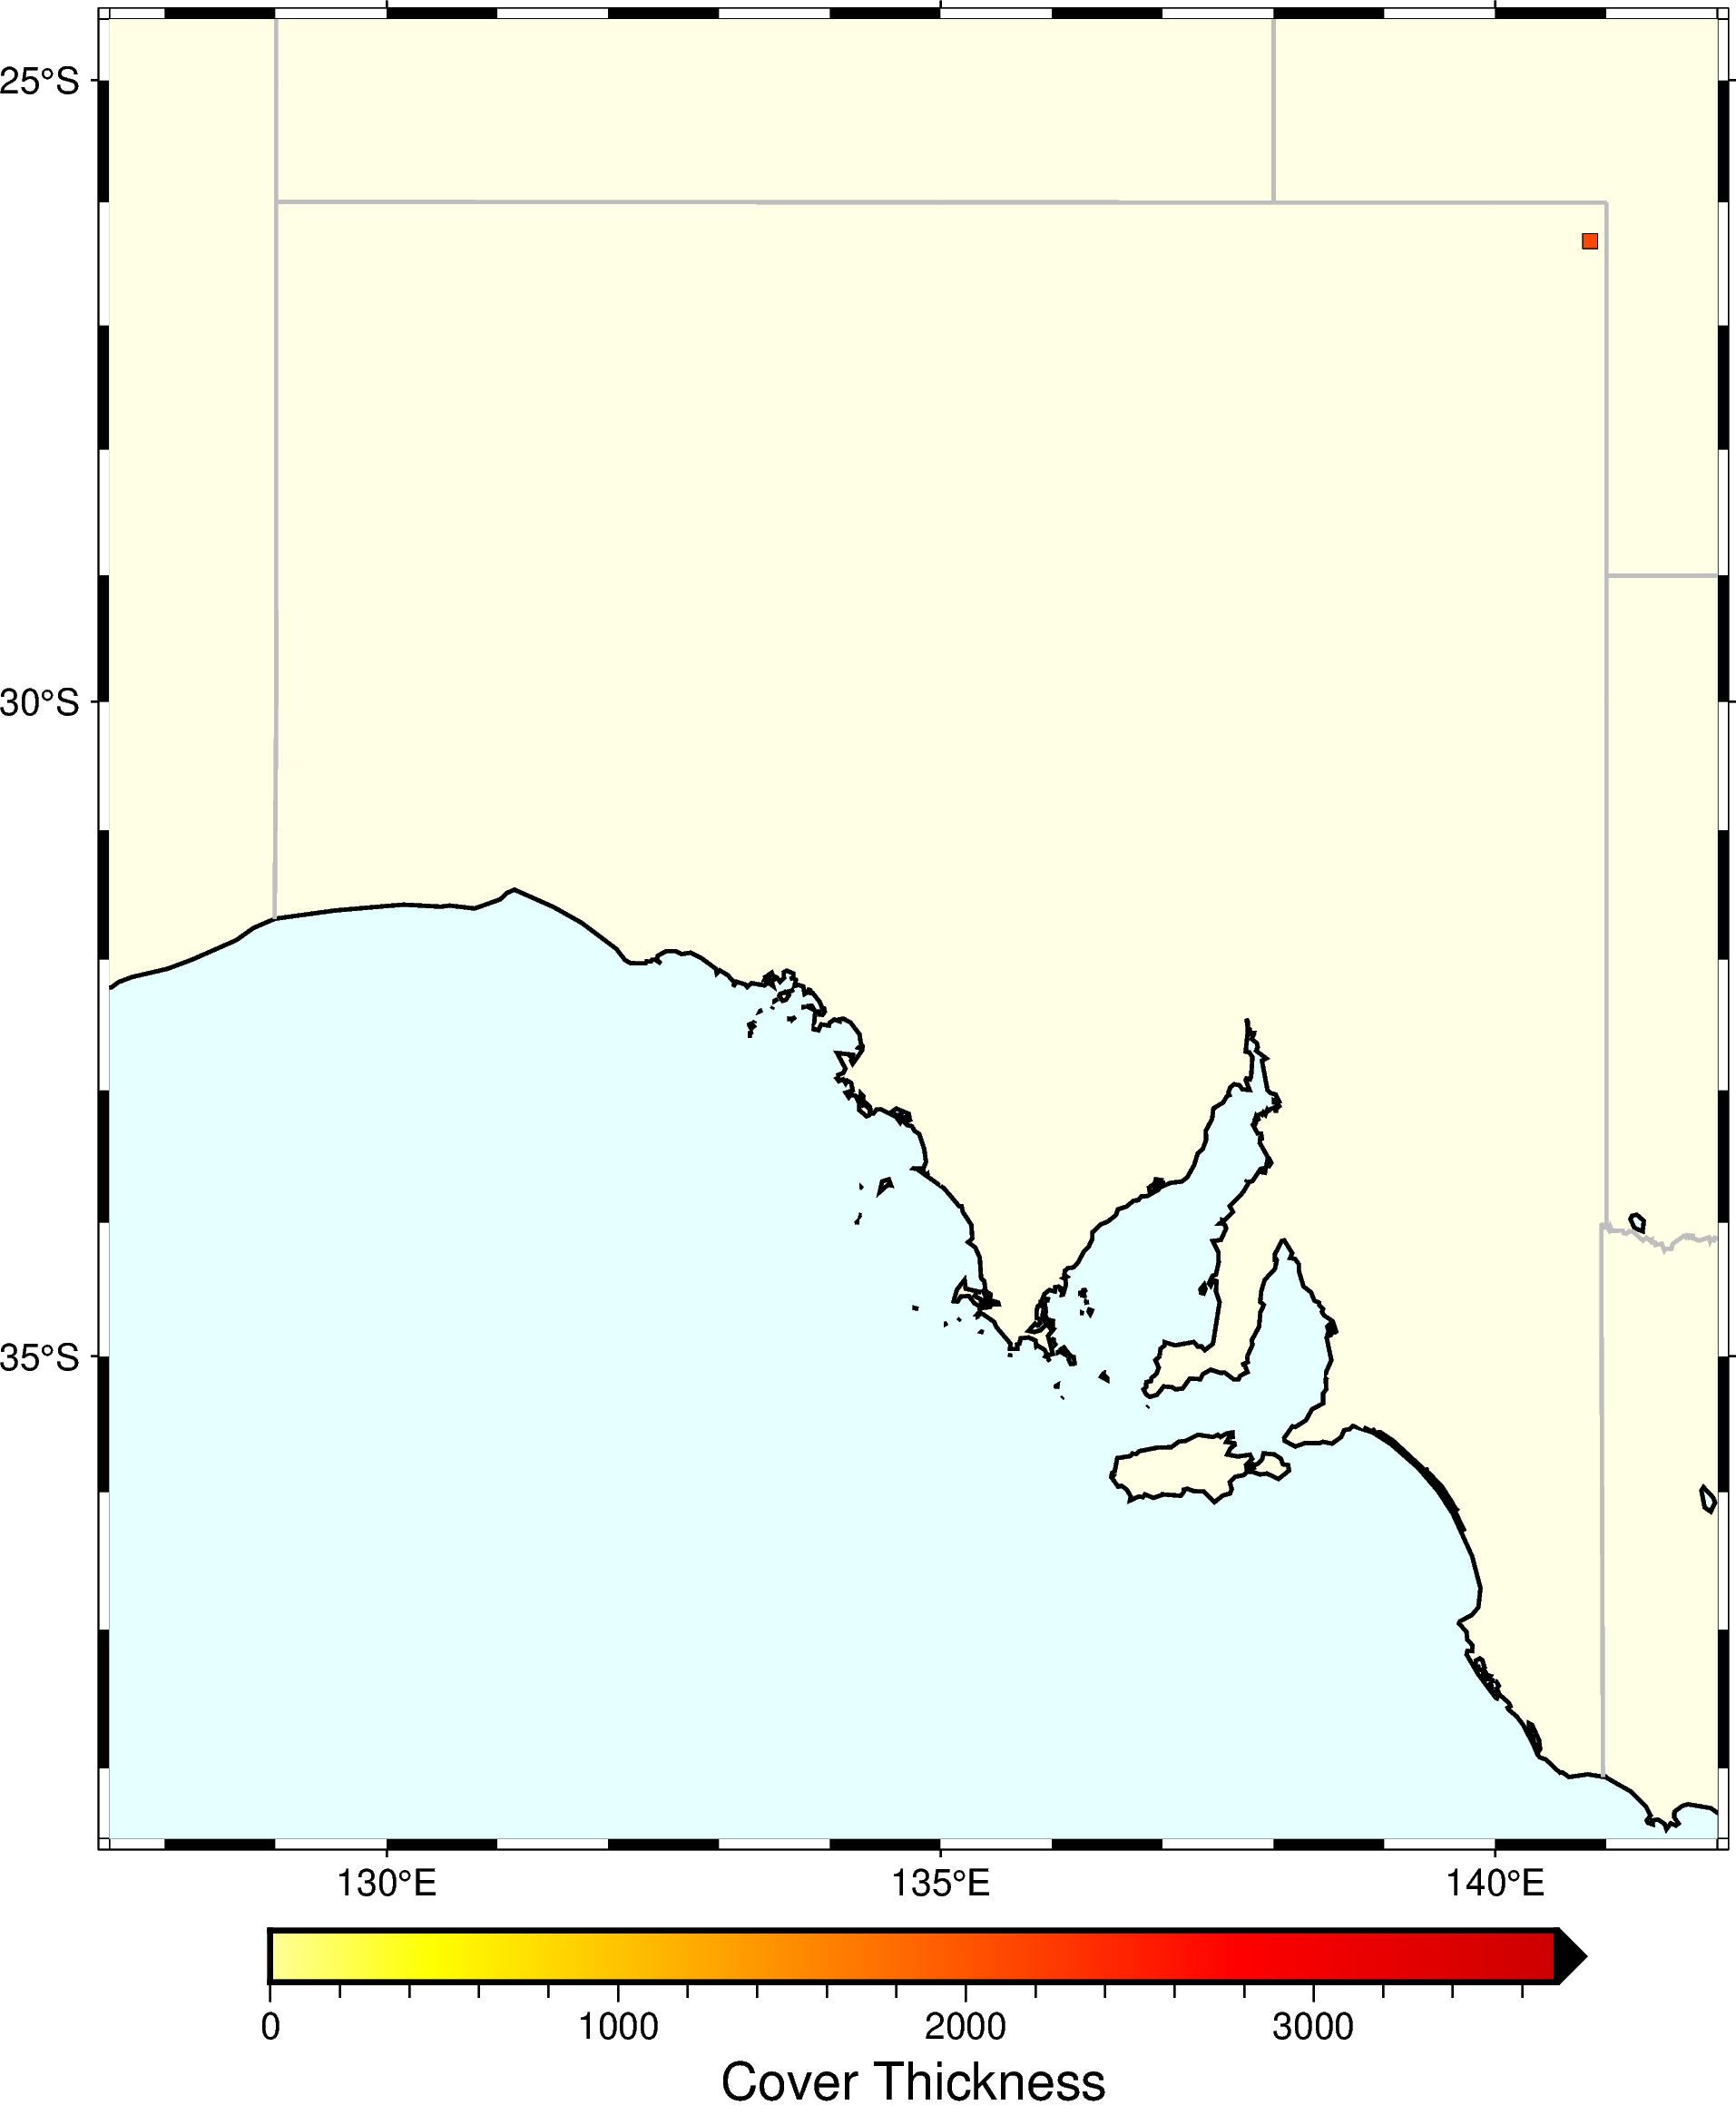

In [6]:
fig = pygmt.Figure()
projection = f"M12/11/15"
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
fig.basemap(region=region, projection=projection)
fig.coast(
    shorelines=1,
    land="#ffffe6",
    water="#e6ffff",
    borders="2/1p,grey",
    projection=projection,
    region=region,
)
pygmt.makecpt(cmap="hot", truncate=[0.3, 0.9], series=[SA.COVR_THICK.min(), SA.COVR_THICK.max()], reverse=True)
x = SA.ADJGDA94_X
y = SA.ADJGDA94_Y
NESA = SA[(x>140) & (y > -30)] #North East South Australia
example_borehole = NESA.iloc[NESA.ADJGDA94_Y.argmax()]
fig.plot(x=[example_borehole.ADJGDA94_X],
         y=[example_borehole.ADJGDA94_Y],
         fill=[example_borehole.COVR_THICK],
         cmap=True,
         style=f"sc",
         pen="0p",
         size=[0.2])
fig.colorbar(
    region=region,
    projection=projection,
    frame=["af+lCover Thickness"],
    position="JBC+ef",
)
fig.show()

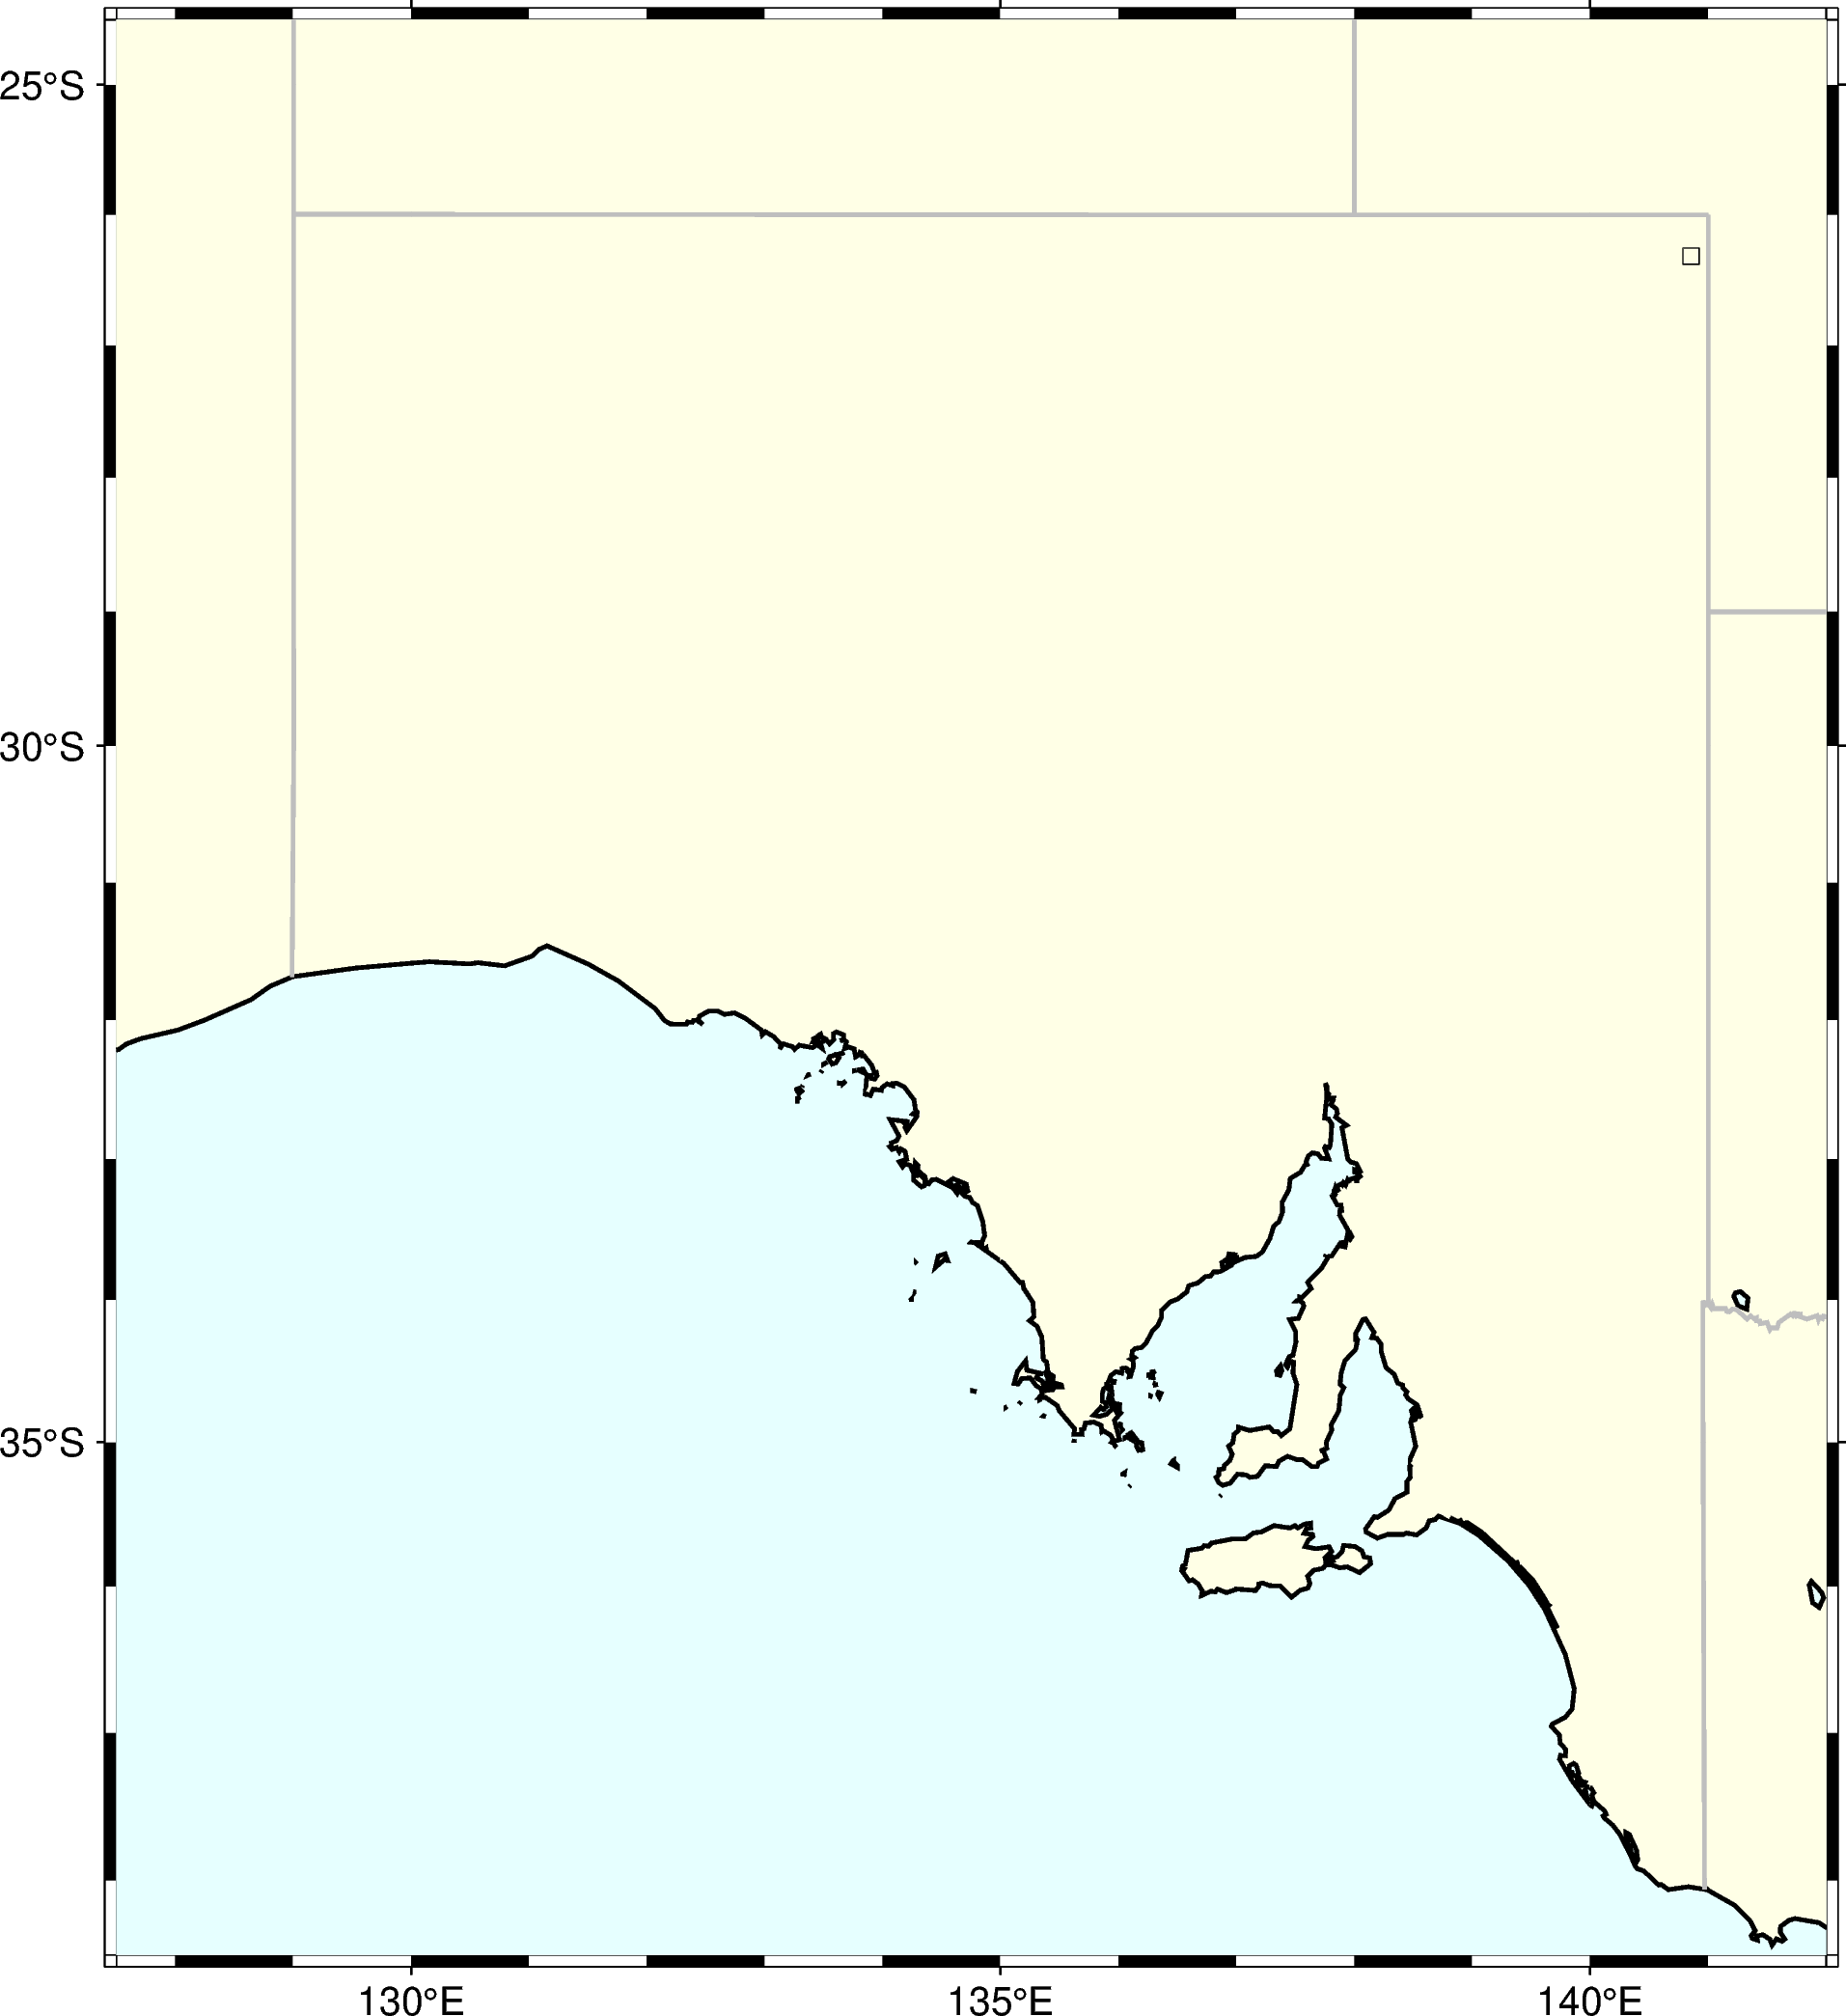

In [7]:
# check we can find a ABSUC borehole close to GSSA borehole
nearest = absuc.iloc[absuc.distance(example_borehole.geometry).argmin()]
fig = pygmt.Figure()
projection = f"M12/11/15"
ln_min, ln_max = (127.5, 142)
lt_min, lt_max = (-38.5, -24.5)
region = [ln_min, ln_max, lt_min, lt_max]
fig.basemap(region=region, projection=projection)
fig.coast(
    shorelines=1,
    land="#ffffe6",
    water="#e6ffff",
    borders="2/1p,grey",
    projection=projection,
    region=region,
)
fig.plot(x=[nearest.GDA94_LONGITUDE],
         y=[nearest.GDA94_LATITUDE],
         style=f"sc",
         pen="0.2p",
         size=[0.2])
fig.show()

In [8]:
units = absuc[absuc["GA_BOREHOLE_GUID"] == nearest["GA_BOREHOLE_GUID"]]
units

,GA_BOREHOLE_GUID,BOREHOLE_NAME,GDA94_LATITUDE,GDA94_LONGITUDE,DATUM_NAME,TD_MD_M,SOURCE_UNIT,GA_UNIT,GA_ASUD_NO,TOP_MD_M,BASE_MD_M,TOP_AHD_M,BASE_AHD_M,Z_AHD_M,HIERARCHY,PREFERRED,geometry
GA_GUID,,,,,,,,,,,,,,,,,
{b59e3b2f-d186-43e5-8422-39f9cbf9ca75},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Mackunda Fm,Mackunda Formation,10952.0,605.0,717.0,-450.07,-562.07,-562.07,260,TB,POINT (140.85426 -26.31930)
{43ec13f3-8ece-4dc8-aa04-4f9a2b952e12},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Allaru Mdst,Allaru Mudstone,291.0,717.0,1010.5,-562.07,-855.57,-855.57,260,TB,POINT (140.85426 -26.31930)
{d985e970-79b2-4a56-bfbe-e7a3c93036ff},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Toolebuc Fm,Toolebuc Formation,18375.0,1010.5,1060.5,-855.57,-905.57,-905.57,260,TB,POINT (140.85426 -26.31930)
{25f24beb-1fa0-4cdd-bcf1-cabf964d4d31},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Wallumbilla Fm,Wallumbilla Formation,19323.0,1060.5,1272.5,-905.57,-1117.57,-1117.57,260,TB,POINT (140.85426 -26.31930)
{4e2ace0f-d448-4af0-a202-43c46f67d900},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Cadna-owie Fm,Cadna-owie Formation,3284.0,1272.5,1329.0,-1117.57,-1174.07,-1174.07,260,B,POINT (140.85426 -26.31930)
{6885ce57-871e-4f4b-95dc-774b67fc3820},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Murta Fm,Murta Formation,13577.0,1329.0,1350.0,-1174.07,-1195.07,-1195.07,260,B,POINT (140.85426 -26.31930)
{67c316a5-3747-494f-b4d8-e00543870612},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Namur Sst,Namur Sandstone,13738.0,1350.0,1436.0,-1195.07,-1281.07,-1281.07,260,B,POINT (140.85426 -26.31930)
{b2b9002d-f1eb-4243-87e4-1b9edecc8091},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Westbourne Fm,Westbourne Formation,19796.0,1436.0,1526.0,-1281.07,-1371.07,-1371.07,260,B,POINT (140.85426 -26.31930)
{dac3989a-1622-4930-84ab-59b2e26abb13},{05edbca8-f30b-44c4-82fb-9b10c8ff06b7},998,-26.319301,140.854263,Kelly Bushing (KB),2157.0,Adori Sst,Adori Sandstone,143.0,1526.0,1558.0,-1371.07,-1403.07,-1403.07,260,B,POINT (140.85426 -26.31930)


Scrape Australian Stratigraphic Units Database to determine if a unit is sedimentary

In [12]:
class ASUDScraper:
    """
    A simple scraper, the purpose of which is to determine if a geological unit
    is in a sedimentary province
    """
    def __init__(self, timeout=60):
        self.base_url = "https://asud.ga.gov.au/search-stratigraphic-units/results/"
        self.initalise_driver(timeout)
        self.timedout_units = []

    def initalise_driver(self, timeout):
        options = Options()
        options.headless = True
        self.driver = webdriver.Chrome(ChromeDriverManager().install(), options=options)
        self.wait = WebDriverWait(self.driver, timeout=timeout)

    def get_unit(self, asud_no):
        """
        input: asud_no - unique identifier for the Australian
        Stratigraphic Units Database
        """
        self.driver.get(f"{self.base_url}{asud_no}")
        try:
            element = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//ga-search-stratigraphic-units-results-details/div/div/div[2]/table/tbody"))
            return element
        except TimeoutException as e:
            self.timedout_units.append(asud_no)
            return None
    
    def is_sedimentary(self, asud_no):
        link = self.get_unit(asud_no)
        if link is None:
            return False
        link.click()
        try:
            table = self.wait.until(lambda driver: driver.find_element(By.XPATH, "//ga-geological-province/div/div[1]/div[1]/table"))
            row = self.wait.until(lambda driver: table.find_element(By.XPATH, ".//tbody/tr[last()]"))
        except TimeoutException as e:
            self.timedout_units.append(asud_no)
            return False
        
        try:
            sedimentary = re.search("Type:\s+sedimentary", row.text)
        except UnboundLocalError:
            sedimentary = False

        return True if sedimentary else False
    
    def cleanup(self):
        self.driver.close()
        


In [13]:
def get_sedimentary_units(units):
    scraper = ASUDScraper()
    sedimentary = [unit for unit in tqdm(units) if scraper.is_sedimentary(unit)]
    timedout = copy(scraper.timedout_units)
    scraper.cleanup()
    return sedimentary, timedout

In [15]:
asud_nos = absuc["GA_ASUD_NO"].unique()
asud_nos = asud_nos[~np.isnan(asud_nos)]

In [16]:
parallel = False

In [17]:
if parallel:
    n_cpus = os.cpu_count()
    asud_nos = np.pad(asud_nos, pad_width=(0, n_cpus - asud_nos.size % n_cpus), constant_values=0)
    batches = np.reshape(asud_nos, (n_cpus, -1))
    result = Parallel(n_jobs=n_cpus)(delayed(get_sedimentary_units)(batch) for batch in batches)
else:
    sedimentary_units, timedout = get_sedimentary_units(asud_nos)

/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_99782/2493110391.py:12: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_99782/2493110391.py:12: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_99782/2493110391.py:12: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_99782/2493110391.py:12: DeprecationWarning: headless property is deprecated, instead use add_argument('--headless') or add_argument('--headless=new')
/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_99782/2493110391.py:12: DeprecationWarning: headless property is deprecated, instead use add_argument('--

KeyboardInterrupt: 